# Introduction

This Jupyter Notebook incorporates the customer segmentation of the provided users towards the objective of PART II - Analyze Users of the main assignment.

# Libraries
In the next cell, the necessary libraries are imported. Note that the necessary conda environment is attached in the project's repository, demanded to run this script. 

In [1]:
import pandas as pd, seaborn as sns, warnings, os, glob
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt, patches as mpatches

## Script utils
sns.set_style("dark")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  
pd.set_option('display.max_rows', 100)

# Functions

The next cell incorporates the necessary functions that will be used in the continuance.

In [2]:

def bin_values(tag, init_lims):
    """
    This function is mainly used to bin data into custom limits as vectorized application on a Series of a DataFrame.

    :param tag: specific row of dataframe to be binned
    :param init_lims: array of integers which will be used to bin the data
    :return: string literal denoting the corresponding bin
    """
    ## initial string for export
    common_str = 'Below '
    
    ## Iterate through the limits
    for cur_lim in init_lims:

        ## Check which case
        if tag <= cur_lim:
            return common_str + str(cur_lim)
            
    ## In case of no return, include above the final limit
    return f'Above {cur_lim}'


#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final



def eval_Kmeans(tag,num_max_comp = 10):
    sse={}
    tag_series = trans_rfm[tag]
    for k in range(1, num_max_comp):
        sse[k] = KMeans(n_clusters=k, max_iter=1000).fit(tag_series).inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title(f'{tag} Clusters')
    plt.xlabel("Number of cluster")
    plt.show()

def custom_Kmeans(df,tag,num_clusters = 4,random_state = 1243):
    #apply clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    kmeans.fit(df[tag])
    return kmeans.predict(df[tag])

    
## ------------------- Plotting utils -------------------

def plot_details(**kwargs):
    plt.title(kwargs['title'],fontsize=10) if 'title' in kwargs else plt.title('')
    plt.xlabel(kwargs['xlabel']) if 'xlabel' in kwargs else plt.xlabel('')
    plt.ylabel(kwargs['ylabel']) if 'ylabel' in kwargs else plt.ylabel('')
    plt.legend(title=kwargs['legend_title']) if 'legend_title' in kwargs else plt.legend('')
    plt.grid(True)

    
def scatter_plot(data, x, y, **kwargs):
    sns.scatterplot(data = data,
                    x = x,
                    y = y,
                    hue = kwargs['hue'],
                    palette = kwargs['palette'])
    plot_details(**kwargs)


# Data Import

A dedicated folder of 'data' is created in the main project folder to incorporate any potential data production. Initially, the _orders.csv_ file should be placed inside. In terms of capacity, the _csv_ file is converted into a _.parquet_ file with the following script, where the string literal _UTC_ is removed from the order_timestamp and converted into _Europe/Athens_ from _UTC_.

In [3]:
## Search for one level above folder for data path and being independent for .csv file name
path = os.path.abspath('..')
csv_files = glob.glob(os.path.join(path + '/data/' , "*.csv"))

## Read csv file
init_df = pd.read_csv(csv_files[0])

## Replace the UTC file
init_df['order_timestamp'] = init_df['order_timestamp'].str.replace("[A-Z]", "",regex=True)
init_df = init_df.set_index('order_timestamp')
init_df.index = pd.to_datetime(init_df.index, utc=True)
init_df.index = init_df.index.tz_convert('Europe/Athens')
init_df.to_parquet(path='../data/orders.parquet', engine='pyarrow' )

Afterwards, the parquet file can be read

In [4]:
init_df = pd.read_parquet('../data/orders.parquet')
init_df.head()

,order_id,user_id,city,cuisine,paid_cash,amount
order_timestamp,,,,,,
2022-01-18 17:41:28+02:00,7322173742136,94223136441,Αίγιο,Breakfast,True,3.6
2022-01-02 19:50:50+02:00,7210978616924,204794985423,Αγρίνιο,Breakfast,True,1.9
2022-01-04 10:37:12+02:00,7221232906132,12703920390,Αγρίνιο,Breakfast,True,1.7
2022-01-31 13:33:05+02:00,7399605199800,673310109528,Λιβαδειά,Breakfast,True,3.0
2022-01-10 13:18:28+02:00,7264221279744,673310109528,Λιβαδειά,Breakfast,True,3.0


The dataset describes order transactions taking place in Greece through efood online delivery. Each transaction represents a buying order. The fields of the dataset are listed below:
 
* __user_id (hashed)__, as unique identifier for each customer
* __order_id (hashed)__, as unique identifier for each order
* __cuisine__, as a description for type of food
* __city__, as the main city where the order was executed
* __paid cash__, as if the customer paid with cash or card
* __amount__, as the total amount of each transaction (in EUR)

By briefly opening the file to review the format of the first samples, it can be seen:

- The _amount_ feature contains the prices and it is assumed that are in EUR.


# Explonatory Data Analysis

In the next section, the dataset will be explored, in terms of erroneous data, null values, etc. The main skeleton will be comprised from main points, which will be examined towards the contribution to the main objective. By checking the information of the dataframe:

In [5]:
init_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 534270 entries, 2022-01-18 17:41:28+02:00 to 2022-01-05 17:45:52+02:00
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   order_id   534270 non-null  int64  
 1   user_id    534270 non-null  int64  
 2   city       534270 non-null  object 
 3   cuisine    534270 non-null  object 
 4   paid_cash  534270 non-null  bool   
 5   amount     534270 non-null  float64
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 25.0+ MB


For the entire dataset, there are no NaN values. Additionally, all types are correctly adjusted, after the time manipulation that was done before the creation of the parquet file. In the next cell, the unique users are examined. Adding to that, the users with 1 order can be extracted as they cannot be useful part of the insight study.

In [6]:
print(f"Number of unique customers: {init_df.user_id.nunique()}")

number_trans = init_df.groupby('user_id').count()['order_id']
reg_cust = init_df[init_df.user_id.isin(number_trans[number_trans > 1].index)]

print(f"Number of unique customers with more than 1 order: {reg_cust.user_id.nunique()}")


Number of unique customers: 121943
Number of unique customers with more than 1 order: 81108


The unique values of city and cuisine are:

In [7]:
print(f"Unique cities are: {reg_cust.city.unique()}")
print('------------------------------------------------------------')
print(f"Unique cuisines are: {reg_cust.cuisine.unique()}")

Unique cities are: ['Αίγιο' 'Αγρίνιο' 'Λιβαδειά' 'Λαμία' 'Βόλος' 'Λάρισα' 'Ιωάννινα'
 'Φλώρινα' 'Νάουσα' 'Δράμα' 'Ξάνθη' 'Αλεξανδρούπολη' 'Ρόδος' 'Άργος'
 'Ναύπλιο' 'Ζάκυνθος' 'Μεσολόγγι' 'Λευκάδα' 'Θήβα' 'Άρτα' 'Γρεβενά'
 'Γιαννιτσά' 'Βέροια' 'Αλεξάνδρεια' 'Ορεστιάδα' 'Διδυμότειχο' 'Λέρος'
 'Γύθειο' 'Αμαλιάδα' 'Ναύπακτος' 'Αράχωβα' 'Έδεσσα' 'Αίγινα' 'Νάξος'
 'Αλίαρτος' 'Οινόφυτα' 'Ιστιαία' 'Μεγαλόπολη' 'Μύκονος' 'Λεωνίδιο'
 'Γαργαλιάνοι' 'Αριδαία' 'Φιλιατρά' 'Ηγουμενίτσα' 'Βασιλικό' 'Άνδρος']
------------------------------------------------------------
Unique cuisines are: ['Breakfast' 'Italian' 'Meat' 'Street food']


From the cell output, it can be seen that the city and the cuisine do not depict any erroneous issue. As instructed in the assignment, the rest of the cuisines will be clustered into _efood Total_

In [8]:
reg_cust.loc[:,'cuisine_filter'] = reg_cust.loc[:,'cuisine']
reg_cust.loc[reg_cust['cuisine'] != 'Breakfast', 'cuisine_filter'] = 'efood Total'
reg_cust

,order_id,user_id,city,cuisine,paid_cash,amount,cuisine_filter
order_timestamp,,,,,,,
2022-01-18 17:41:28+02:00,7322173742136,94223136441,Αίγιο,Breakfast,True,3.6,Breakfast
2022-01-02 19:50:50+02:00,7210978616924,204794985423,Αγρίνιο,Breakfast,True,1.9,Breakfast
2022-01-04 10:37:12+02:00,7221232906132,12703920390,Αγρίνιο,Breakfast,True,1.7,Breakfast
2022-01-31 13:33:05+02:00,7399605199800,673310109528,Λιβαδειά,Breakfast,True,3.0,Breakfast
2022-01-10 13:18:28+02:00,7264221279744,673310109528,Λιβαδειά,Breakfast,True,3.0,Breakfast
...,...,...,...,...,...,...,...
2022-01-29 00:25:04+02:00,7383295241752,314285338626,Αλεξανδρούπολη,Street food,True,11.9,efood Total
2022-01-29 00:39:29+02:00,7383425578320,586121418057,Αλεξανδρούπολη,Street food,True,9.9,efood Total
2022-01-24 21:29:34+02:00,7364485291992,29082002418,Αλεξανδρούπολη,Street food,True,15.1,efood Total


Afterwards, the cuisine will be explored, in terms of costs and overall insights

In [22]:
## Groupby for each customer the number of orders, the sum of the total_order_value, the average total_order_value
grouped_trans = reg_cust.groupby(['user_id','cuisine_filter']).agg({
                                    'amount': ['count','sum','mean'],
                                    })

## Immediate flattening and rename of columns
grouped_trans.columns = ['_'.join(col) for col in grouped_trans.columns.values]
grouped_trans.columns = ['num_of_orders','total_cost','average_cost_per_order']

# ## Binning into custom thresholds and in 4 quantiles the average cost per order
# grouped_trans['bin_avg_cost'] = grouped_trans['average_cost_per_order'].apply(lambda x: bin_values(x, [10,20,50]) )
# grouped_trans['bin_avg_cost_quantiles'] = pd.qcut(grouped_trans['average_cost_per_order'], 4).apply(lambda x: f'Below {x.right}')
grouped_trans.reset_index(level=1, inplace=True)
grouped_trans.head(5)



,cuisine_filter,num_of_orders,total_cost,average_cost_per_order
user_id,,,,
108938802,efood Total,3,44.2,14.733333
110361993,Breakfast,1,4.3,4.300000
110361993,efood Total,10,132.7,13.270000
144777339,Breakfast,14,60.8,4.342857
145424244,Breakfast,1,11.9,11.900000


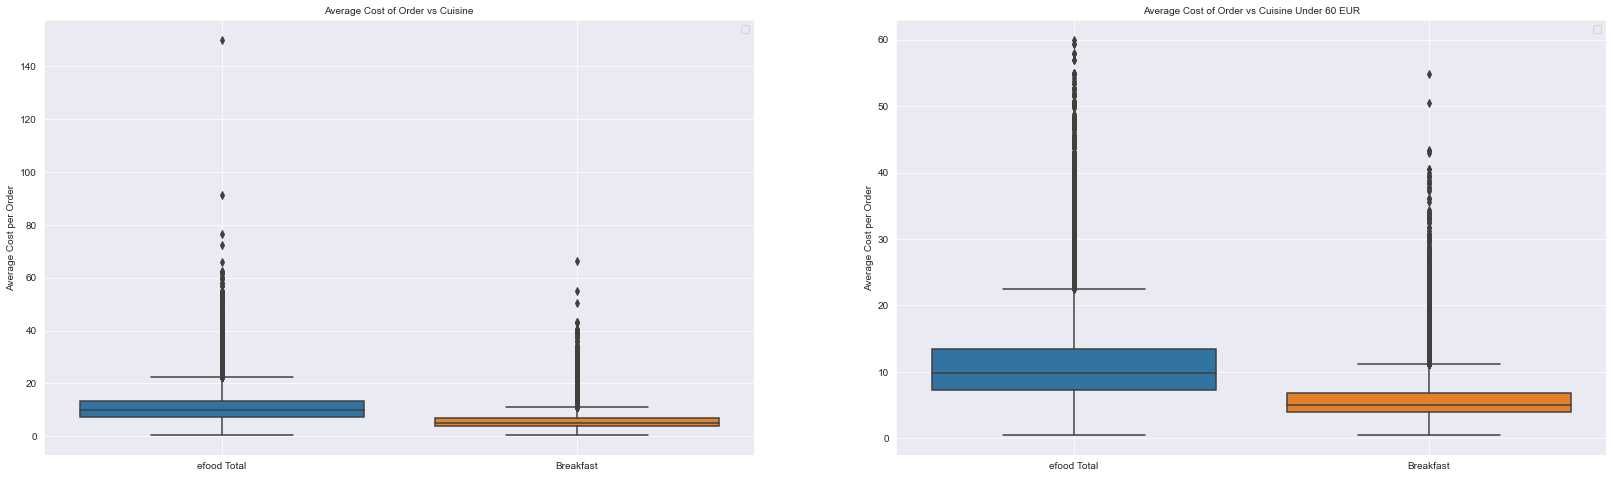

In [31]:
## Plot Average Cost of Order vs Cuisine per Customer 
fig = plt.figure(figsize=(28,8))
plt.subplot(121)
sns.boxplot(data = grouped_trans, x ='cuisine_filter', y = 'average_cost_per_order')
plot_details(ylabel='Average Cost per Order', title='Average Cost of Order vs Cuisine')

## Plot Average Cost of Order vs Cuisine per Customer 
## Zoom only below 60 EUR cost
plt.subplot(122)
sns.boxplot(data= grouped_trans[grouped_trans.average_cost_per_order <= 60], x='cuisine_filter', y ='average_cost_per_order')
plot_details(ylabel='Average Cost per Order', title='Average Cost of Order vs Cuisine Under 60 EUR')


As it can be seen, in average, the median Average Cost per Order for Breakfast is concentrated at 6 EUR, slightly lower than the rest of the efood Totan at 10 EUR. As a consequence, the next cell examines the correlation of the total amount per the number of orders, based on custom binning and quantiles on the average cost per order 

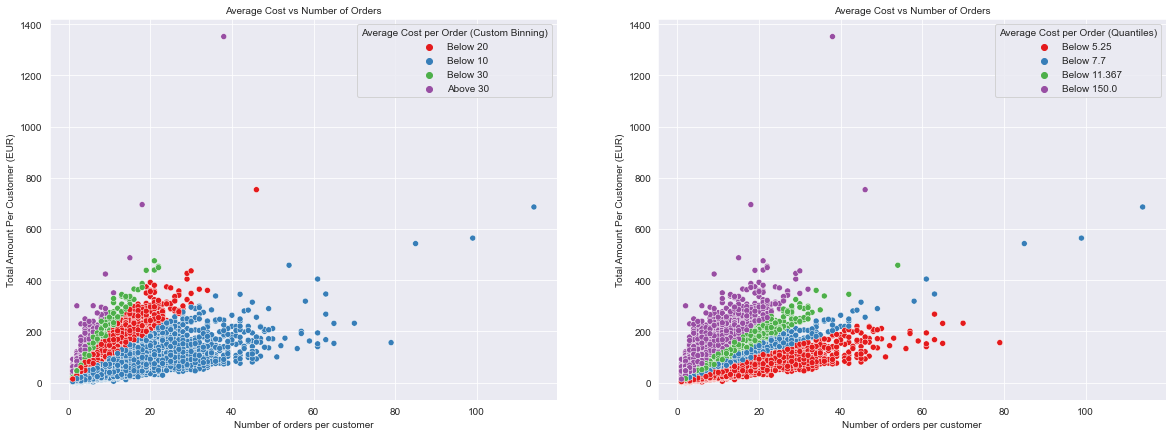

In [37]:
## Custom Binning and Quantiles
grouped_trans['bin_avg_cost'] = grouped_trans['average_cost_per_order'].apply(lambda x: bin_values(x, [10,20,30]) )
grouped_trans['bin_avg_cost_quantiles'] = pd.qcut(grouped_trans['average_cost_per_order'], 4).apply(lambda x: f'Below {x.right}')

## Plot
fig = plt.figure(figsize=(20,7))
plt.subplot(121)
scatter_plot(data= grouped_trans, x = 'num_of_orders', y = 'total_cost', hue='bin_avg_cost', title = "Average Cost vs Number of Orders", palette='Set1',
                     xlabel = 'Number of orders per customer' , ylabel = 'Total Amount Per Customer (EUR)', legend_title = 'Average Cost per Order (Custom Binning)')

plt.subplot(122)
scatter_plot(data= grouped_trans, x = 'num_of_orders', y = 'total_cost' , hue='bin_avg_cost_quantiles',title = "Average Cost vs Number of Orders",
                     xlabel = 'Number of orders per customer' , ylabel = 'Total Amount Per Customer (EUR)', legend_title = 'Average Cost per Order (Quantiles)', palette='Set1')

plt.show()

From the derived plots, many observations can be detailed. Initially, as an expected insight, the relationship of the entire amount spent vs the number of orders scales accordingly to the average cost for each order. On this basis, it is depicted that 75% of the customers execute orders with small amounts, lower that 12 EUR, having a highly skewed distribution on the transactions. Thus, there are 2 brief types of customers:

* small-cost transactions and high frequency
* high-cost transactions and small order frequency

In general, a clear correlation between the sum of amounts per customer and the number of orders per customer is obvious.

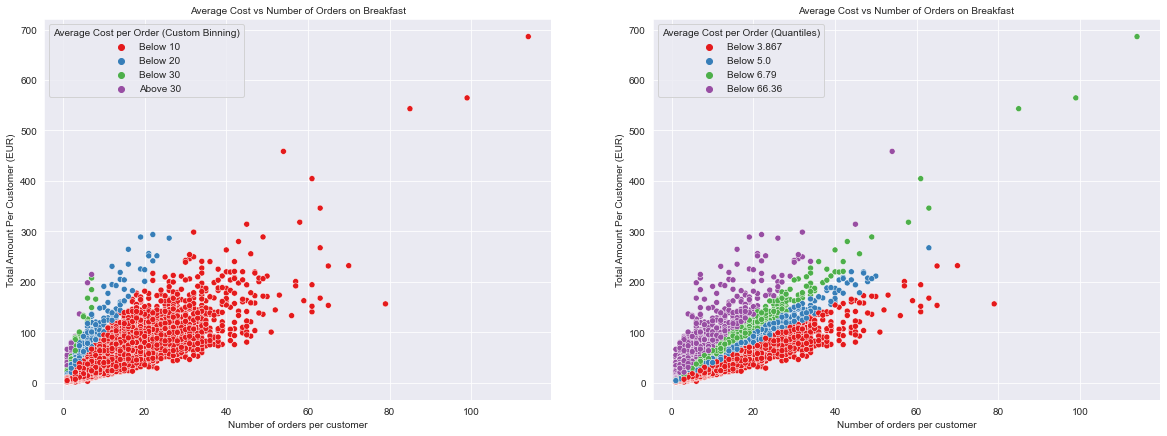

In [39]:
## Custom Binning and Quantiles on Breakfast
grouped_trans['bin_avg_cost_break'] = grouped_trans.loc[grouped_trans.cuisine_filter == 'Breakfast', 'average_cost_per_order'].apply(lambda x: bin_values(x, [10,20,30]) )
grouped_trans['bin_avg_cost_quantiles_break'] = pd.qcut(grouped_trans.loc[grouped_trans.cuisine_filter == 'Breakfast', 'average_cost_per_order'], 4).apply(lambda x: f'Below {x.right}')

plot_df = grouped_trans.loc[grouped_trans.cuisine_filter == 'Breakfast']


## Plot Breakfast
fig = plt.figure(figsize=(20,7))
plt.subplot(121)
scatter_plot(data= plot_df, x = 'num_of_orders', y = 'total_cost', hue='bin_avg_cost_break', title = "Average Cost vs Number of Orders on Breakfast", palette='Set1',
                     xlabel = 'Number of orders per customer' , ylabel = 'Total Amount Per Customer (EUR)', legend_title = 'Average Cost per Order (Custom Binning)')

plt.subplot(122)
scatter_plot(data= plot_df, x = 'num_of_orders', y = 'total_cost' , hue='bin_avg_cost_quantiles_break',title = "Average Cost vs Number of Orders on Breakfast",
                     xlabel = 'Number of orders per customer' , ylabel = 'Total Amount Per Customer (EUR)', legend_title = 'Average Cost per Order (Quantiles)', palette='Set1')

plt.show()

The same behaviour is found, yet 75% of the average breakfast order is limited up to 7 EUR. Observing a daily view in the next cell:

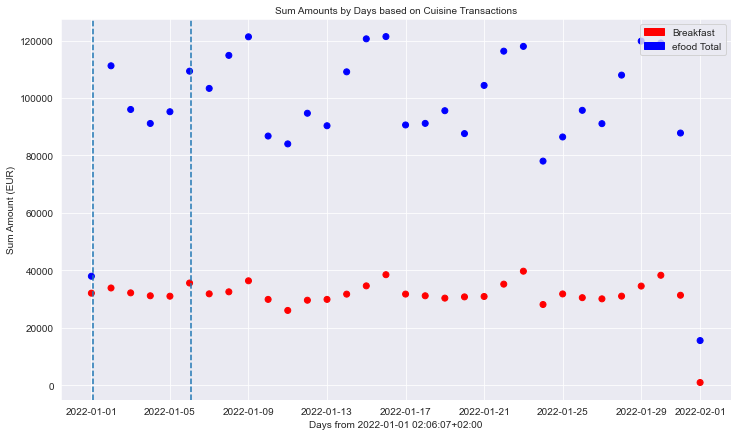

In [40]:
## Get daily info on cuisines
temp_df = reg_cust.groupby([pd.Grouper(freq='D'),'cuisine_filter']).agg({'amount': ['sum']}).reset_index()

# Make daily sum amounts on cuisines
fig, ax = plt.subplots(figsize=(12,7))

colors = {'Breakfast':'red', 'efood Total':'blue'}
ax.scatter(x = temp_df.order_timestamp, y = temp_df.amount['sum'],
            c = temp_df.cuisine_filter.apply(lambda x: colors[x]))


patches = [mpatches.Circle((0,0), 2, color = "red", label = "Breakfast"),
          mpatches.Circle((0,0), 2, color = 'blue', label = 'efood Total')]
plt.legend(handles=patches, loc=1)

## Bank Holidays
plt.axvline(x=pd.Timestamp('2022-01-01'), linestyle='--')
plt.axvline(x=pd.Timestamp('2022-01-06'), linestyle='--')
plt.title("Sum Amounts by Days based on Cuisine Transactions",fontsize=10)
plt.xlabel(f'Days from {init_df.index.min()}')
plt.ylabel('Sum Amount (EUR)')
plt.grid(True)

plt.show()

Initially, the two vertical dashed lines are denoting the National Bank Holidays of Greece. As for 01/01/2022, it can be seen that efood Total is significantly reduced compared with previous activity as it is national bank holiday after Christmas, thus online delivery is logically reduced. Now, from 06/01/2022, it is also expected to have increased number of amounts due to people eating home. In general, there is a periodic behaviour, for both Breakfast and efood Total. This behaviour starts with increasing sum amount from the Tuesdays up to Sunday, where it falls again back. This is in logical phychological terms and expected since people are prone to ordering more towards the end of the week.

# Clustering Behavior

One of the common customer segmentation techniques is the Recency, Frequency and Monetary (RFM) model. RFM modelling comes to identify these groups with recency, frequency, and monetary as metrics used to determine the customer’s lifetime value, answering the questions of how recently, how often a purchase is done and how much money are spent. More specifically, the model describes the three factors of:

* Recency, referring to the last time of a customer purchase, since it is more likely to repeat compared to other who have not bought something for a long time
* Frequency, referring to how many times a customer has bought within a specific time period, since it is more likely to continue to come back as having past frequent transactions.
* Monetary Value, referring to the amount of money a customer has spent within a specific time period.

After the calculation of these metrics,
In this assignment, the segmentation is dictated to be done in the _frequency_ and the _order_ value. Before going forward it needs to be noted that the frequency and the monetary value (sum) was used but not insightful outcome was provided from the clusters. Also, what would be of great examination is to insert the Average Amount per Order in the clustering module as it would inject the notion of engagement, aside from recency. Yet, for revenue, the mean amount per order and customer will be calculated below.

In [13]:
# Calculate Frequency and Mean Amount in each order
trans_rfm = reg_cust.reset_index().groupby('user_id').agg({
                                                'order_timestamp':'max',
                                                'order_id': pd.Series.nunique, # Unique orders to mark Frequency
                                                'amount': 'mean' # Sum of the monetary value
                                                    })

trans_rfm['Recency'] = (trans_rfm.order_timestamp.max() - pd.to_datetime(trans_rfm.order_timestamp)).dt.days
trans_rfm.drop('order_timestamp',inplace=True,axis=1)
trans_rfm.columns = ['Revenue','Frequency','Recency']

trans_rfm = trans_rfm.reset_index()
trans_rfm


,user_id,Revenue,Frequency,Recency
0,108938802,3,14.733333,4
1,110361993,11,12.454545,7
2,144777339,14,4.342857,0
3,145424244,12,13.562500,1
4,153963390,3,12.166667,3
...,...,...,...,...
81103,685130616450,2,14.450000,0
81104,685180816278,2,4.550000,0
81105,685290272604,2,7.750000,0
81106,685327404951,2,9.200000,0


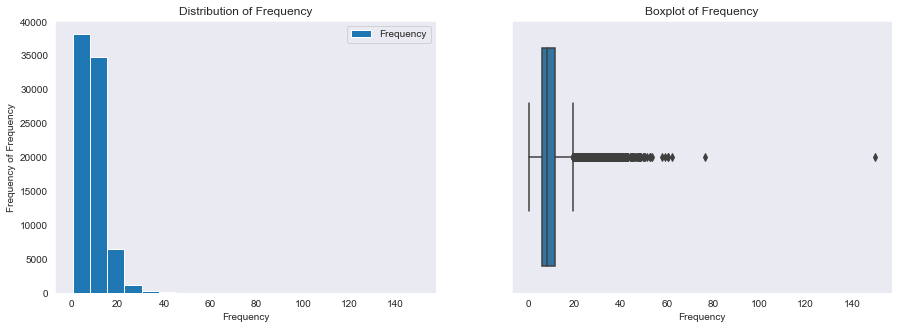

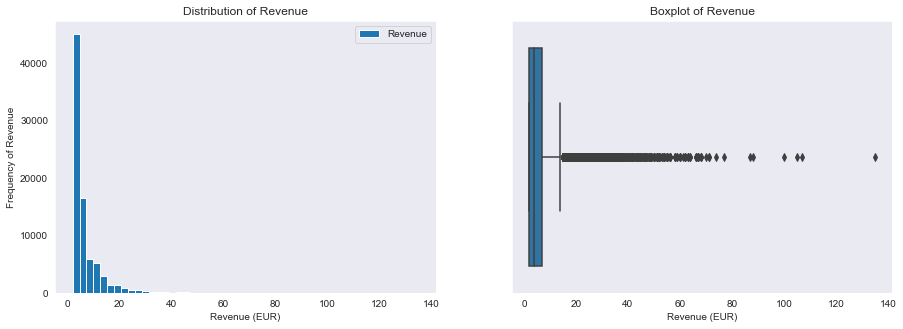

In [14]:
## Plot distibution of frequency
plt.figure(figsize=(15,5))
plt.subplot(121)
trans_rfm['Frequency'].plot.hist(bins=20)
plt.xlabel('Frequency')
plt.ylabel('Frequency of Frequency')
plt.title('Distribution of Frequency')
plt.legend(loc=1)

## Boxplot
plt.subplot(122)
sns.boxplot(x = 'Frequency', data = trans_rfm)
plt.xlabel('Frequency')
plt.title('Boxplot of Frequency')
plt.show()

## Plot distibution of revenue_USD
plt.figure(figsize=(15,5))
plt.subplot(121)
trans_rfm['Revenue'].plot.hist(bins=50)
plt.xlabel('Revenue (EUR)')
plt.ylabel('Frequency of Revenue')
plt.title('Distribution of Revenue')
plt.legend(loc=1)

## Boxplot
plt.subplot(122)
sns.boxplot(x = 'Revenue', data = trans_rfm)
plt.xlabel('Revenue (EUR)')
plt.title('Boxplot of Revenue')
plt.show()

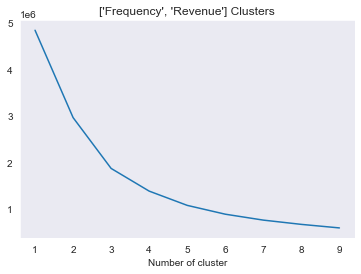

In [15]:
eval_Kmeans(['Frequency','Revenue'])
# eval_Kmeans('Revenue')

In [16]:
## Initialize scaler objects
std_scal_rev = StandardScaler()
std_scal_freq = StandardScaler()

## Standardize for KMeans
trans_rfm['Revenue'] = std_scal_rev.fit_transform(trans_rfm['Revenue'].values.reshape(-1,1))
trans_rfm['Frequency'] = std_scal_freq.fit_transform(trans_rfm['Frequency'].values.reshape(-1,1))


## KMeans in each RFM feature
trans_rfm['FMCluster'] = custom_Kmeans(trans_rfm,['Frequency','Revenue'], 6,random_state=222)
## Return after KMeans
trans_rfm['Revenue'] = std_scal_rev.inverse_transform(trans_rfm['Revenue'].values.reshape(-1,1))
trans_rfm['Frequency'] = std_scal_freq.inverse_transform(trans_rfm['Frequency'].values.reshape(-1,1))


## KMeans in each RFM feature
# trans_rfm['FrequencyCluster'] = custom_Kmeans(trans_rfm,'Frequency', 4,random_state=222)

#order the cluster numbers
# trans_rfm = order_cluster('RevenueCluster', 'Revenue',trans_rfm,True)
# trans_rfm = order_cluster('FrequencyCluster', 'Frequency',trans_rfm,True)

## Display statistics for each cluster
print('Frequency Clusters:')
display(trans_rfm.groupby('FMCluster')['Frequency'].describe())
print('-----------------------------------')
print('Revenue Clusters:')
display(trans_rfm.groupby('FMCluster')['Revenue'].describe())



display(trans_rfm)

Frequency Clusters:


,count,mean,std,min,25%,50%,75%,max
FMCluster,,,,,,,,
0,24416.0,10.148013,1.412454,7.937500,8.933333,10.000000,11.300000,13.080000
1,12179.0,7.117767,2.418040,0.500000,5.419762,6.865385,8.554356,20.636364
2,28154.0,5.741266,1.431334,0.466667,4.800000,5.900000,6.900000,7.943750
3,2349.0,25.969318,6.104843,20.800000,22.200000,24.100000,27.750000,150.000000
4,2374.0,6.150294,2.491200,1.260870,4.490756,5.758683,7.379844,19.345833
5,11636.0,15.779702,2.098115,12.910000,14.000000,15.300000,17.250000,21.108333


-----------------------------------
Revenue Clusters:


,count,mean,std,min,25%,50%,75%,max
FMCluster,,,,,,,,
0,24416.0,3.986525,1.985206,2.0,2.0,3.0,5.0,10.0
1,12179.0,13.114213,3.380750,9.0,10.0,12.0,15.0,22.0
2,28154.0,4.009377,1.937755,2.0,2.0,3.0,5.0,9.0
3,2349.0,3.172840,1.980508,2.0,2.0,2.0,4.0,38.0
4,2374.0,30.233783,9.267147,22.0,24.0,27.0,33.0,135.0
5,11636.0,3.804916,2.298318,2.0,2.0,3.0,5.0,20.0


,user_id,Revenue,Frequency,Recency,FMCluster
0,108938802,3.0,14.733333,4,5
1,110361993,11.0,12.454545,7,1
2,144777339,14.0,4.342857,0,1
3,145424244,12.0,13.562500,1,1
4,153963390,3.0,12.166667,3,0
...,...,...,...,...,...
81103,685130616450,2.0,14.450000,0,5
81104,685180816278,2.0,4.550000,0,2
81105,685290272604,2.0,7.750000,0,2
81106,685327404951,2.0,9.200000,0,0


In [17]:
# trans_rfm['RFMScore'] = trans_rfm['FrequencyCluster'] + trans_rfm['RevenueCluster']

## Adding to minimize the categories
print('Final Clusters')
trans_rfm.groupby('FMCluster')['Frequency','Revenue'].mean()

Final Clusters


,Frequency,Revenue
FMCluster,,
0,10.148013,3.986525
1,7.117767,13.114213
2,5.741266,4.009377
3,25.969318,3.172840
4,6.150294,30.233783
5,15.779702,3.804916


In [18]:
trans_rfm['final_group'] = 'Low-Value'
trans_rfm.loc[trans_rfm['RFMScore']>=4,'final_group'] = 'Regular' 
trans_rfm.loc[trans_rfm['RFMScore']>=3,'final_group'] = 'High-Value'

merged_df = reg_cust.reset_index().merge(trans_rfm, on='user_id')
merged_df

KeyError: 'RFMScore'

<AxesSubplot:xlabel='FMCluster', ylabel='amount'>

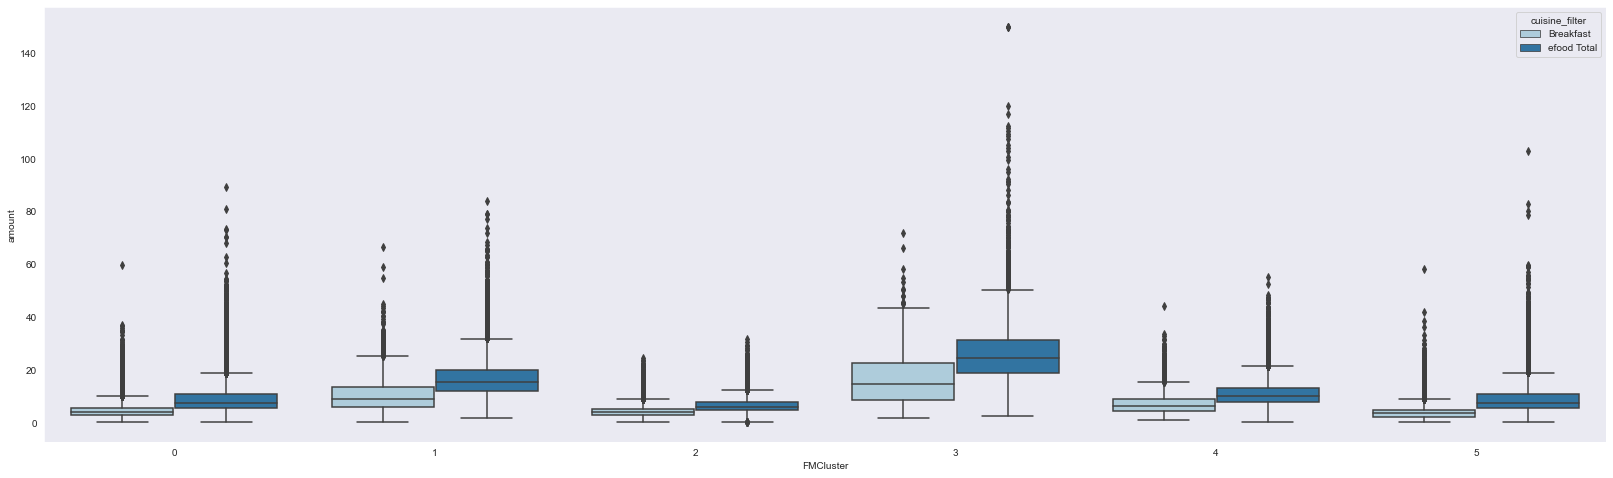

In [ ]:
# vis_df = merged_df.groupby(['RFMScore','cuisine_filter']).agg({'amount':['sum']})
# vis_df.reset_index(level=1,inplace=True)
# vis_df.columns = ['cuisine_filter','avg_amount']
# # vis_df
fig = plt.figure(figsize=(28,8))

sns.boxplot(data=merged_df, x = 'FMCluster', y = 'amount', hue='cuisine_filter' )

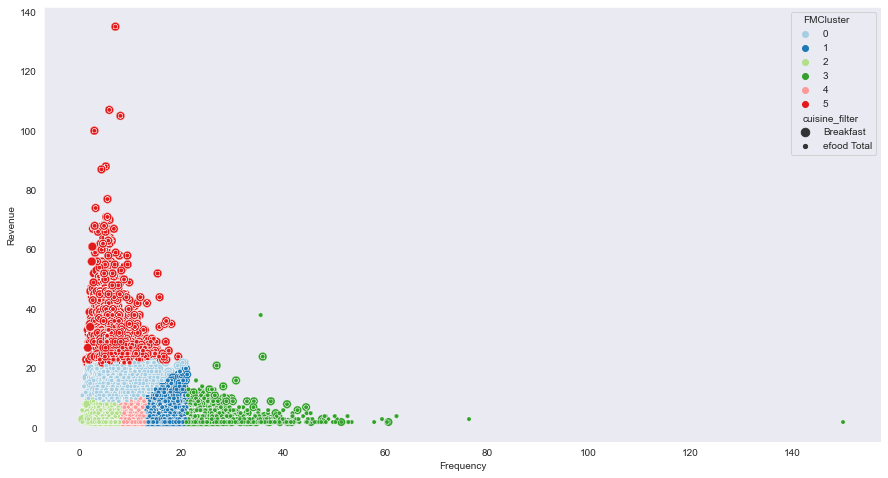

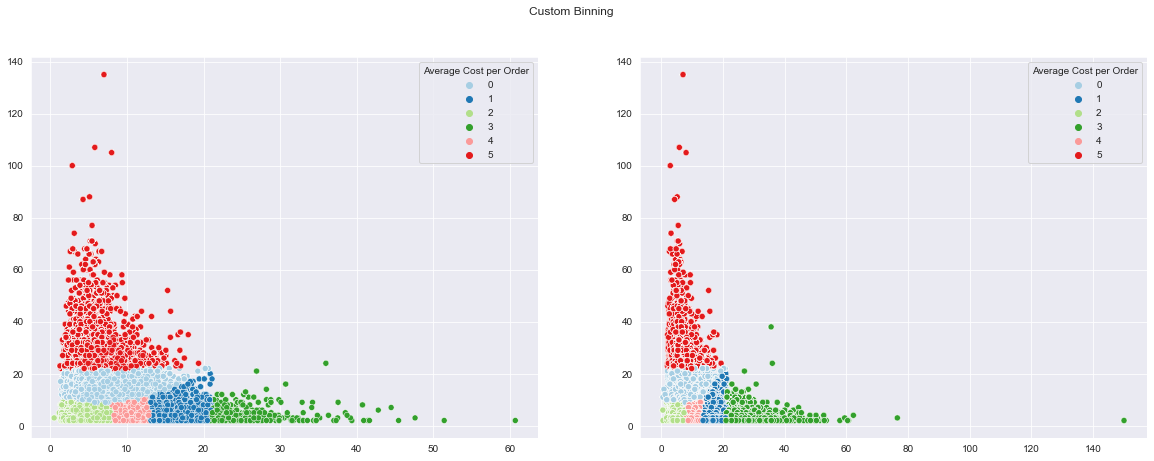

In [ ]:
plt.figure(figsize=(15,8))

sns.scatterplot(data=merged_df, x="Frequency", y="Revenue", hue = 'FMCluster', palette = 'Paired',size='cuisine_filter', markers=['o', 'd'])
# g = sns.jointplot(data=merged_df, x="Frequency", y="Revenue", hue = 'FMCluster', palette = 'Paired', size='cuisine_filter', height = 10)

fig = plt.figure(figsize=(20,7))

fig.suptitle('Custom Binning')
plt.subplot(121)
scatter_plot(data= merged_df[merged_df.cuisine_filter == 'Breakfast'], x = 'Frequency', y = 'Revenue', hue='FMCluster',palette = 'Paired', legend_title = 'Average Cost per Order')

plt.subplot(122)
scatter_plot(data=  merged_df[merged_df.cuisine_filter != 'Breakfast'], x = 'Frequency', y = 'Revenue', hue='FMCluster', palette = 'Paired',legend_title = 'Average Cost per Order')

# #Plot details
# g.ax_joint.set_xlabel('Frequency')
# g.ax_joint.set_ylabel('Revenue (EUR)')
# g.fig.suptitle('Frequency vs Recency')
# g.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
# plt.show()

# Introduction

This Jupyter Notebook incorporates the creation of a PoC model towards the objective of the assignment, the forecasting of  the number of orders &
total_order_value for the rest of March 2019.
We need to forecast for each customer (in the dataset) the number of orders &
total_order_value for the rest of March 2019.


# Libraries
In the next cell, the necessary libraries are imported. Note that the necessary conda environment is attached in the project's repository, demanded to run this script. 

# Introduction

This Jupyter Notebook incorporates the creation of a PoC model towards the objective of the assignment, the forecasting of  the number of orders &
total_order_value for the rest of March 2019.
We need to forecast for each customer (in the dataset) the number of orders &
total_order_value for the rest of March 2019.


# Libraries
In the next cell, the necessary libraries are imported. Note that the necessary conda environment is attached in the project's repository, demanded to run this script. 